In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/krise/Documents/GitHub/private/tidier4ds"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


Rows: 333
Columns: 7
.species       InlineStrings.String15Adelie, Adelie, Adelie, Adelie, Adelie, Ade
.island        InlineStrings.String15Torgersen, Torgersen, Torgersen, Torgersen,
.bill_length_mmFloat64        39.1, 39.5, 40.3, 36.7, 39.3, 38.9, 39.2, 41.1, 38
.bill_depth_mm Float64        18.7, 17.4, 18.0, 19.3, 20.6, 17.8, 19.6, 17.6, 21
.flipper_length_mmInt64          181, 186, 195, 193, 190, 181, 195, 182, 191, 19
.body_mass_g   Int64          3750, 3800, 3250, 3450, 3650, 3625, 4675, 3200, 38
.sex           InlineStrings.String7male, female, female, female, male, female, 


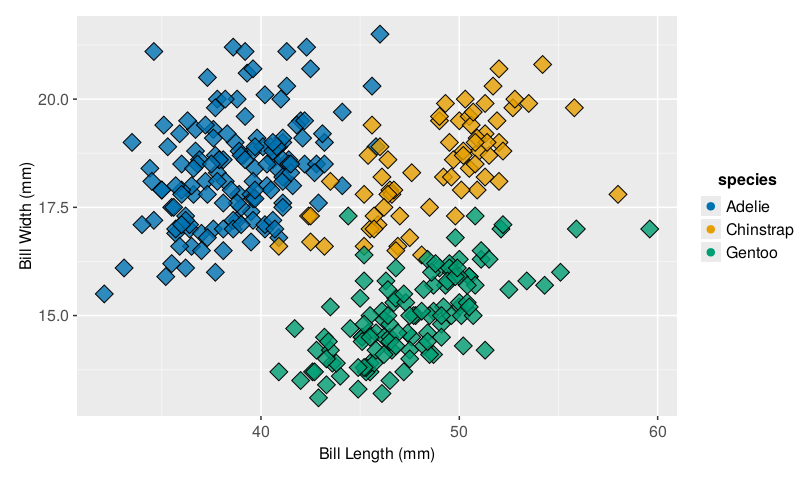

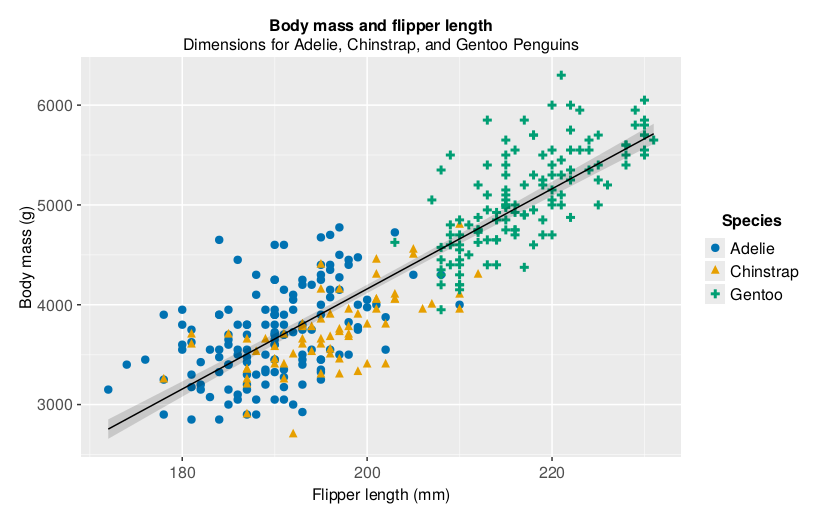

TidierPlots.GGPlot(Any[TidierPlots.Geom(Dict("shape" => :species, "x" => :flipper_length_mm, "color" => :species, "y" => :body_mass_g), Dict{String, Any}("geom_name" => "geom_point"), Layer(identity, nothing, Any[], {}), Layer(AlgebraOfGraphics.Visual(MakieCore.Scatter, {}), nothing, Any[], {}), Layer(identity, nothing, Any[], {}), ["x", "y"], Dict("strokecolor" => "strokecolor", "colour" => "color", "glowcolor" => "glowcolor", "stroke" => "strokewidth", "label" => "text", "alpha" => "alpha", "strokecolour" => "strokecolor", "size" => "markersize", "glowcolour" => "glowcolor", "errorbar_direction" => "direction"…), Dict{Any, Any}()), TidierPlots.Geom(Dict("x" => :flipper_length_mm, "y" => :body_mass_g), Dict{String, Any}("method" => "lm", "geom_name" => "geom_smooth"), Layer(identity, nothing, Any[], {}), Layer(identity, nothing, Any[], {}), Layer(AlgebraOfGraphics.LinearAnalysis{MakieCore.Automatic}(200, false, MakieCore.Automatic(), 0.95), nothing, Any[], {}), ["x", "y"], Dict("strok

In [2]:
using Tidier, PalmerPenguins

penguins = @drop_na(DataFrame(PalmerPenguins.load()))

@glimpse(penguins)

@ggplot(penguins, aes(x = bill_length_mm, y = bill_depth_mm, color = species)) + 
    @geom_point(shape = diamond, 
                size = 20, 
                stroke = 1, 
                strokecolour = "black",
                alpha = 0.8) +
    @labs(x = "Bill Length (mm)", y = "Bill Width (mm)")

@ggplot(penguins,aes(x = flipper_length_mm, y = body_mass_g)) +
  @geom_point(aes(color = species, shape = species)) +
  @geom_smooth(method = "lm") +
  @labs(
    title = "Body mass and flipper length",
    subtitle = "Dimensions for Adelie, Chinstrap, and Gentoo Penguins",
    x = "Flipper length (mm)", y = "Body mass (g)",
    color = "Species", shape = "Species"
  )